# Apresentação do problema

Como um cientista de dados, minha missão é prever o vazamento de receita (revenue leakage) de um hotel. O hotel possui uma base de dados com vários atributos sobre os clientes, características da reserva e se o cliente cancelou sua reserva ou não.

Vamos fazer uma análise e construir uma solução com Machine Learning para prever se o cliente irá cancelar sua reserva ou não. Por fim, iremos analisar as métricas e calcular a economia ao implementar a nossa solução.

OBS.: *Revenue leakege se refere a situações em que uma empresa poderia ter gerado receita, mas por algum motivo não conseguiu capturá-la ou mante-la, resultando em perda financeira potencial.*

# Instalação e importação de bibliotecas

In [ ]:
!pip install catboost

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import numpy as np
import warnings

from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sns.set_theme(style="dark", palette="viridis")
warnings.filterwarnings("ignore")

# Informações sobre os dados

- **Booking_ID**: identificador único de cada reserva
- **no_of_adults**: Número de adultos
- **no_of_children**: Número de crianças
- **no_of_weekend_nights**: Número de noites de fim de semana (sábado ou domingo) que o hóspede ficou ou reservou para ficar no hotel
- **no_of_week_nights**: Número de noites da semana (segunda a sexta-feira) que o hóspede ficou ou reservou para ficar no hotel
- **type_of_meal_plan**: Tipo de plano de refeições reservado pelo cliente
- **required_car_parking_space**: O cliente precisa de vaga de estacionamento? (0 - Não, 1 - Sim)
- **room_type_reserved**: Tipo de quarto reservado pelo cliente. Os valores são cifrados (codificados) pelos Hotéis INN.
- **lead_time**: Número de dias entre a data da reserva e a data de chegada
- **arrival_year**: Ano da data de chegada
- **arrival_month**: Mês da data de chegada
- **arrival_date**: Data do mês
- **market_segment_type**: Designação do segmento de mercado
- **repeated_guest**: O cliente é um hóspede recorrente? (0 - Não, 1 - Sim)
- **no_of_previous_cancellations**: Número de reservas anteriores que foram canceladas pelo cliente antes da reserva atual
- **no_of_previous_bookings_not_canceled**: Número de reservas anteriores que não foram canceladas pelo cliente antes da reserva atual
- **avg_price_per_room**: Preço médio por dia da reserva; os preços dos quartos são dinâmicos. (em euros)
- **no_of_special_requests**: Número total de pedidos especiais feitos pelo cliente (por exemplo, andar alto, vista do quarto, etc.)
- **booking_status**: Indicador que mostra se a reserva foi cancelada ou não

# Funções

In [ ]:
def plot_count(data, column: str | list, sub: list=None, xticks=False, hue=None):
  """Plota a contagem das colunas."""
  if isinstance(column, str):
    column = [column]
  for i, col in enumerate(column):
    if sub:
      plt.subplot(sub[0], sub[1], i+1)
    sns.countplot(data=data, x=col, hue=hue)
    if xticks:
      plt.xticks(rotation=60)
  plt.tight_layout()
  plt.show()

def plot_hist(data, column: str | list, sub: list=None, kde=True, bins=50, hue=None):
  """Plota a coluna em um histograma."""
  if isinstance(column, str):
    column = [column]
  for i, col in enumerate(column):
    if sub:
      plt.subplot(sub[0], sub[1], i+1)
    sns.histplot(data=data, x=col, kde=kde, bins=bins, multiple="stack", hue=hue)
  plt.tight_layout()
  plt.show()

def preprocessor(X_train: pd.DataFrame, X_test: pd.DataFrame, encoder, y_train: None | pd.Series = None):
  """Faz o pré-processamento dos dados utilizando Target Encoder."""
    categorical_features = df.select_dtypes(exclude="number").drop(columns=["booking_status"]).columns
    if isinstance(encoder, TargetEncoder):
      X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features], y_train)
    else:
      X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
    X_test[categorical_features] = encoder.transform(X_test[categorical_features])
    return X_train, X_test

# Leitura dos dados

In [ ]:
df = pd.read_csv("Hotel Reservations.csv")
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [ ]:
df = df.drop(columns=["Booking_ID"]) # Coluna de identificação será inútil para nossa análise

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

A princípio não nenhum valor faltante.

# Análise Exploratória (EDA)

In [ ]:
numerical_features = df.select_dtypes(include="number")
categorical_features = df.select_dtypes(exclude="number")

## Análise Univariada

### Variáveis Numéricas

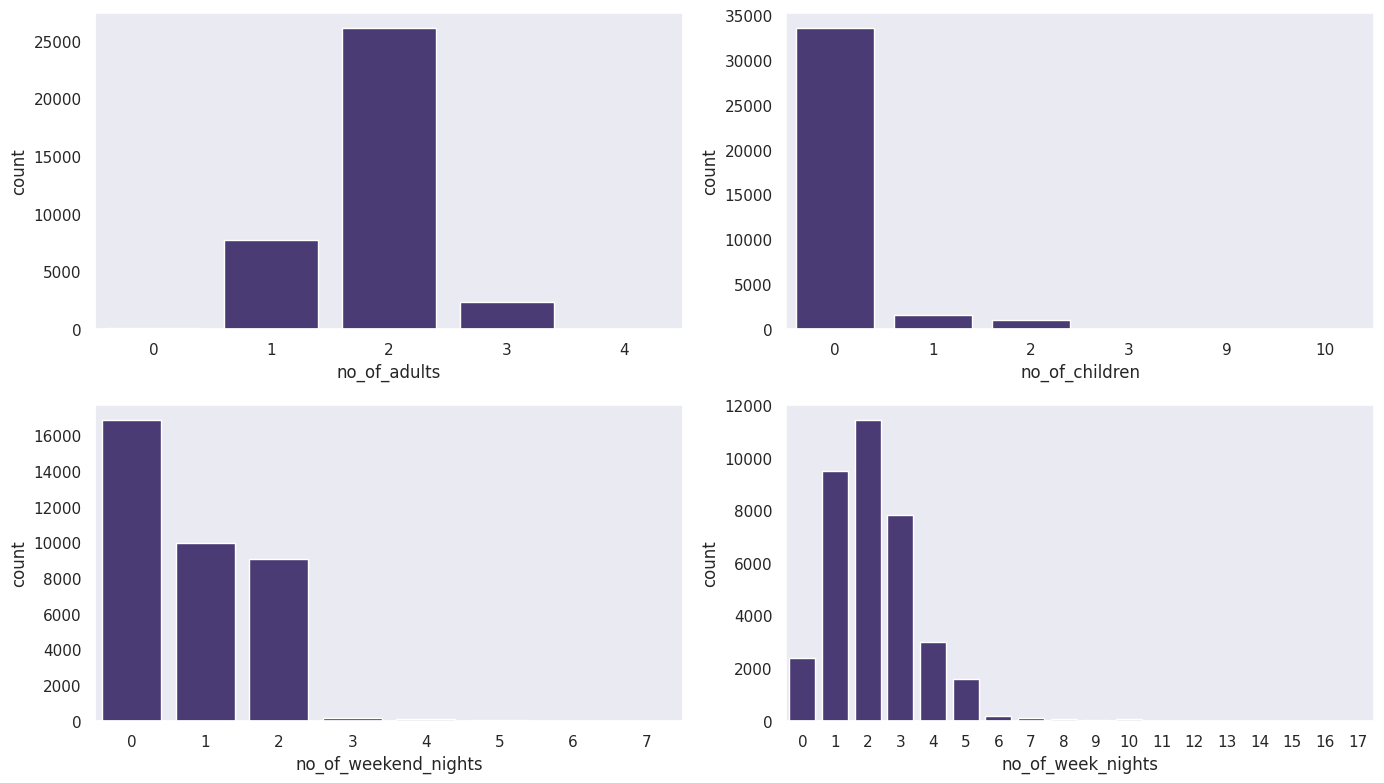

In [ ]:
plt.figure(figsize=(14, 8))
plot_count(data=df, column=["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights"], sub=[2, 2])

Observações:
- A quantidade de adultos que compõe uma reserva é, na maioria das vezes, 2 adultos.
- O número de crianças possui uma enorme assimetria à direita. Em sua maioria o número de crianças que compõe um reserva é 0.
- Também com uma simetria à direita os hóspedes, na maioria das vezes, ficam/reservam de 0 a 2 noites de fim de semana.
- O número de noites em que os hóspedes ficaram/reservaram noites durante a semana possui, também, uma assimetria positiva, com 2 sendo a maior quantidade de vezes.

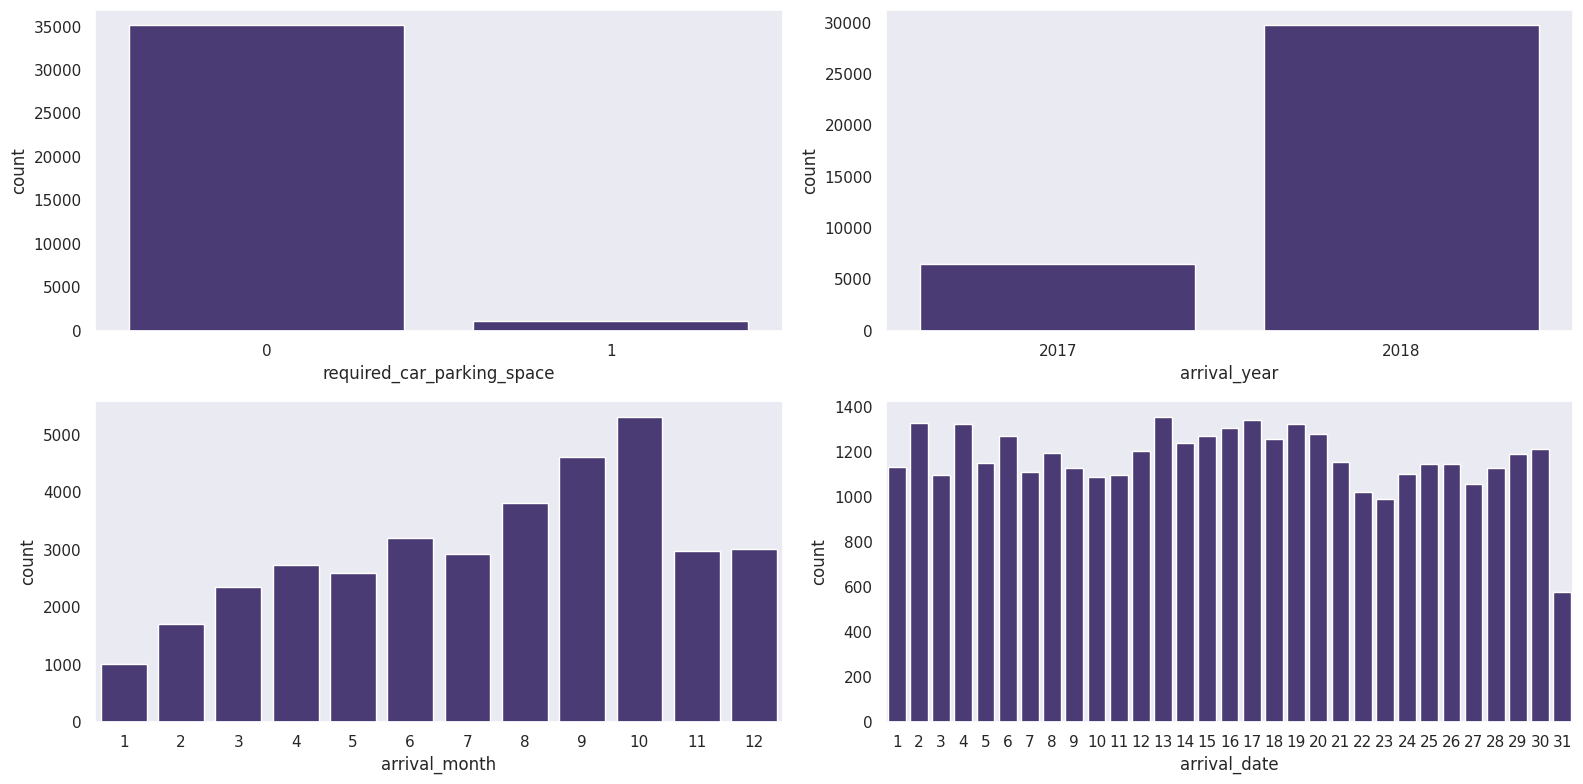

In [ ]:
plt.figure(figsize=(16, 8))
plot_count(data=df, column=["required_car_parking_space", "arrival_year", "arrival_month", "arrival_date"], sub=[2, 2])

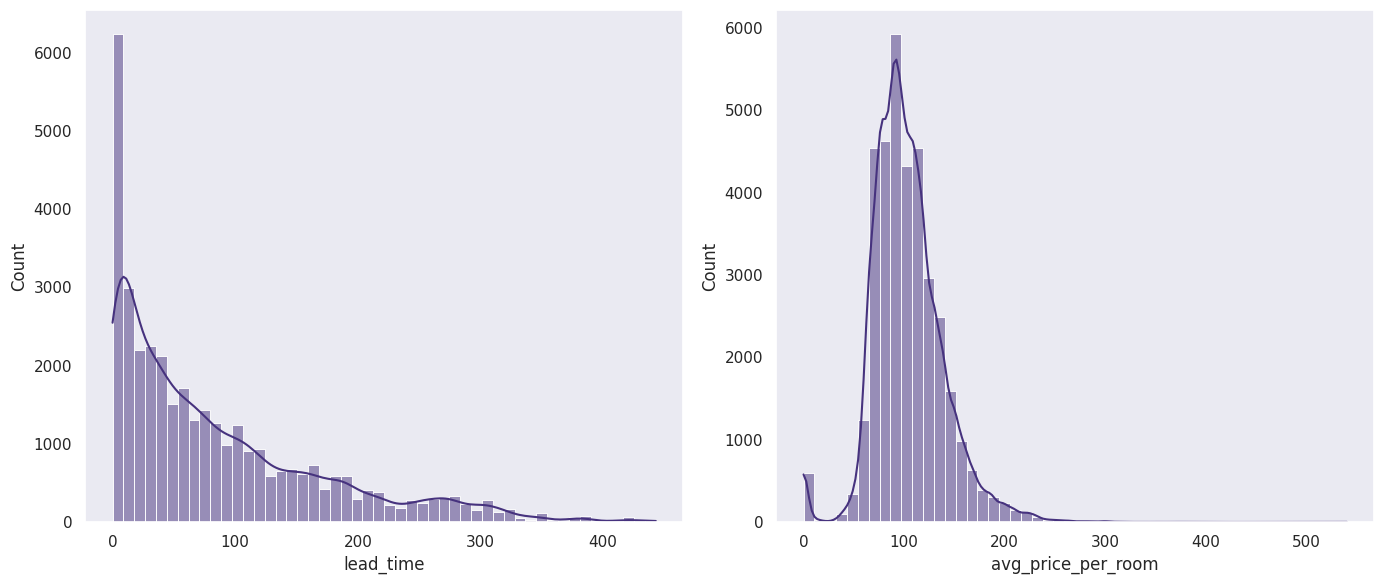

In [ ]:
plt.figure(figsize=(14, 6))
plot_hist(data=df, column=["lead_time", "avg_price_per_room"], sub=[1, 2])

Observações:
- A grande maioria dos hóspedes não possuem preferência de garagem para carro.
- Aproximadamente 78% das reservas foram feitas no ano de 2018.
- Há uma tendência das reservas aumentaram com ao longo do ano, tendo um pico em outubro e diminuindo em novembro e dezembro.
- Os dias dos meses que os hóspedes preferem reservar não parecem seguir nenhuma tendência.
- O número de dias entre a compra e a reserva possui uma assimetria à direita, com a maioria dos hóspedes fazendo a reserva no mesmo dia da compra.
- O preço médio por dia da reserva se concentra ao redor dos 100 euros, tendo mais outliers à direita. É interessante observar que há cerca de 500 instâncias em que o preço médio é 0.

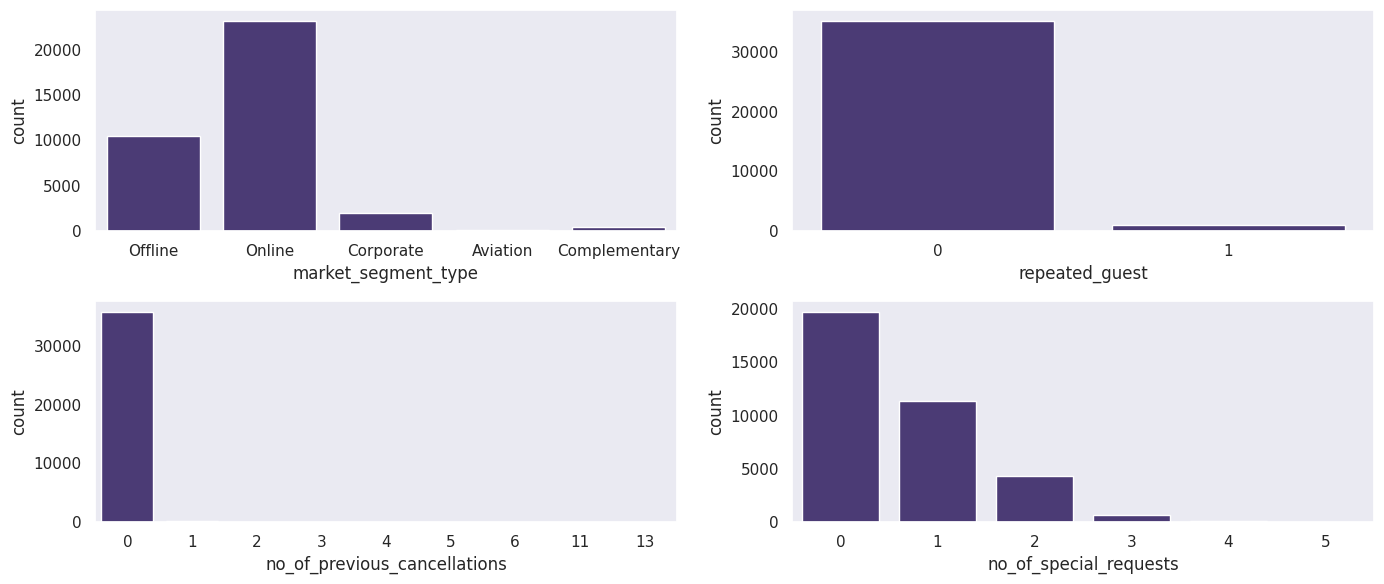

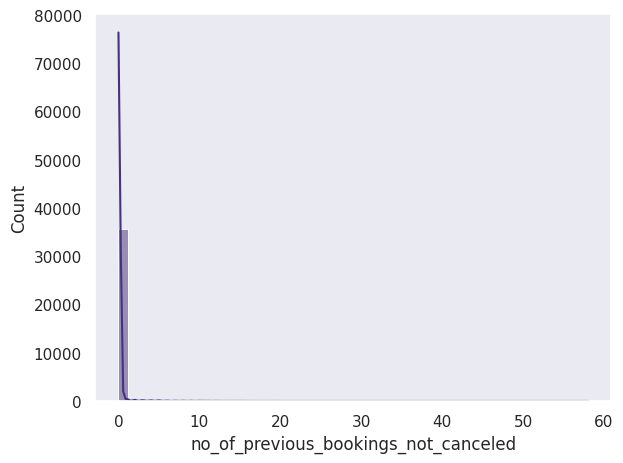

In [ ]:
plt.figure(figsize=(14, 6))
plot_count(data=df, column=["market_segment_type", "repeated_guest", "no_of_previous_cancellations", "no_of_special_requests"], sub=[2, 2])
plot_hist(data=df, column=["no_of_previous_bookings_not_canceled"])

As distribuição acimas são as mais assimétricas dentre as numéricas.
- A grande maioria dos hóspedes não são clientes repetidos.
- A grande maioria dos hóspedes não fizeram nenhum cancelamento antes.
- A variável "no_of_previous_bookings_not_canceled" nos informa a quantidade de reservas que o cliente não cancelou se ele é um cliente repetido. Visto que a maioria dos clientes não são repetidos, a maioria possui valor 0 de cancelamento.
- A variável "no_of_special_requests" apresenta a menor assimetria dentre os quatros com a maior parte dos hóspedes tendo 1 ou 2 pedidos especiais.

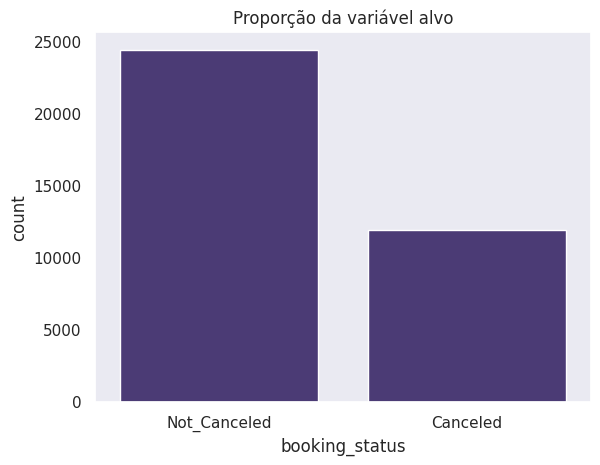

In [ ]:
sns.countplot(data=df, x="booking_status")
plt.title("Proporção da variável alvo")
plt.show()

Nossa variável alvo possui um desbalanceamento, mas não tão grave, com a maioria dos hóspedes não cancelando a reserva.

Mesmo que o número de cancelamentos seja menor que o de não cancelamentos, há uma porção significativa de hóspedes que cancelaram as suas reservas, gerando um preujuízo considerável para o hotel.

### Variáveis Categóricas

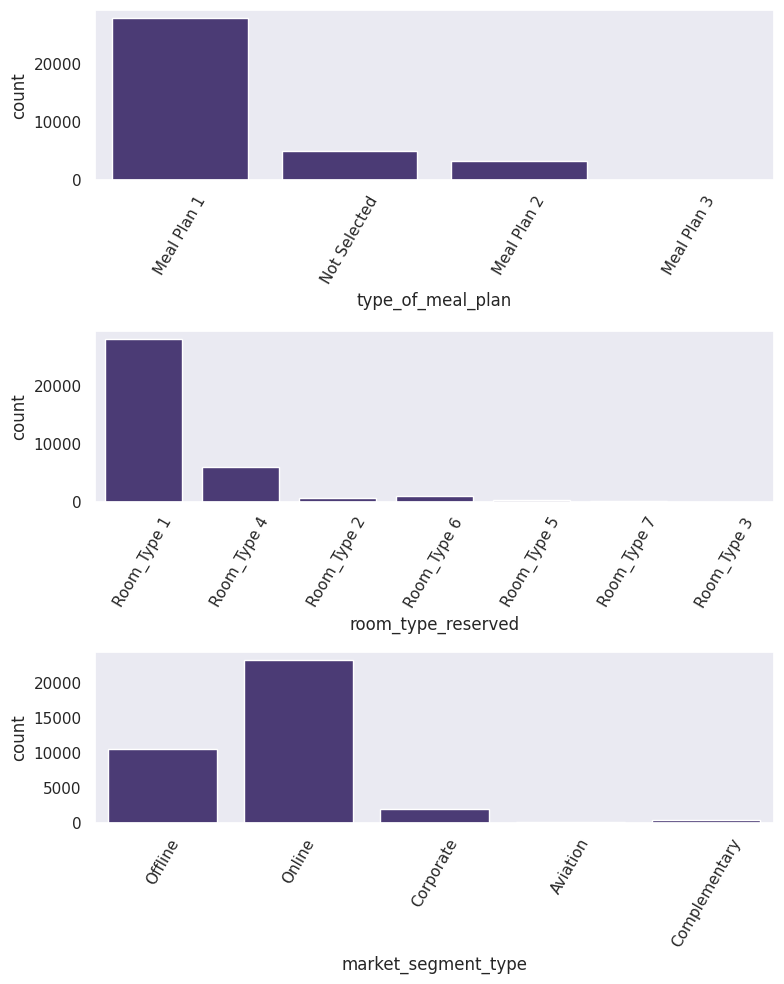

In [ ]:
plt.figure(figsize=(8, 10))
plot_count(data=df, column=["type_of_meal_plan", "room_type_reserved", "market_segment_type"], sub=[3, 1], xticks=True)

Observações:
- O tipo de plano de refeição mais preferido dos hóspedes é o 1. Nenhum hóspede escolheu o tipo 3. Distribuição assimétrica à direita.
- Há também uma assimetria à direita no tipo de quarto reservado. Com o quarto de tipo 1 sendo o mais preferido entre os clientes.
- A maioria dos hóspedes vem de compras online, seguido de offline e corporativa.

## Análise Bivariada

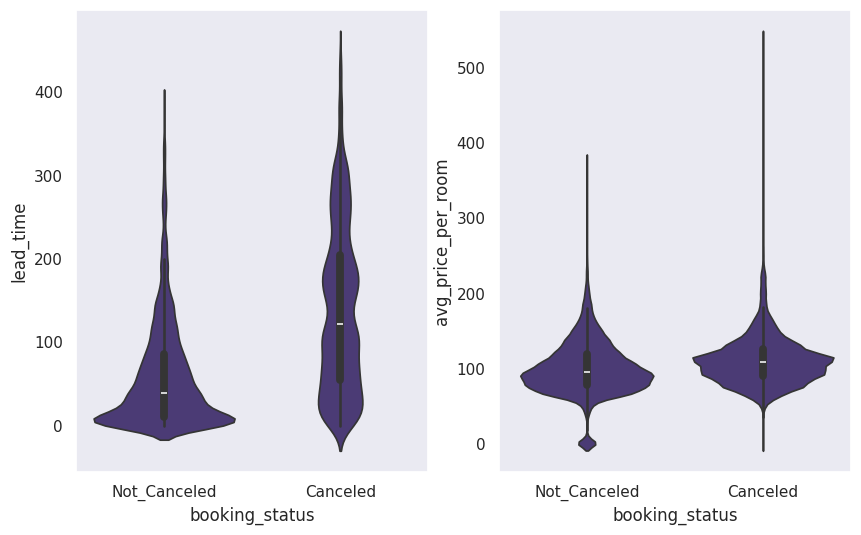

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(121)
sns.violinplot(data=df, x="booking_status", y="lead_time")
plt.subplot(122)
sns.violinplot(data=df, x="booking_status", y="avg_price_per_room")
plt.show()

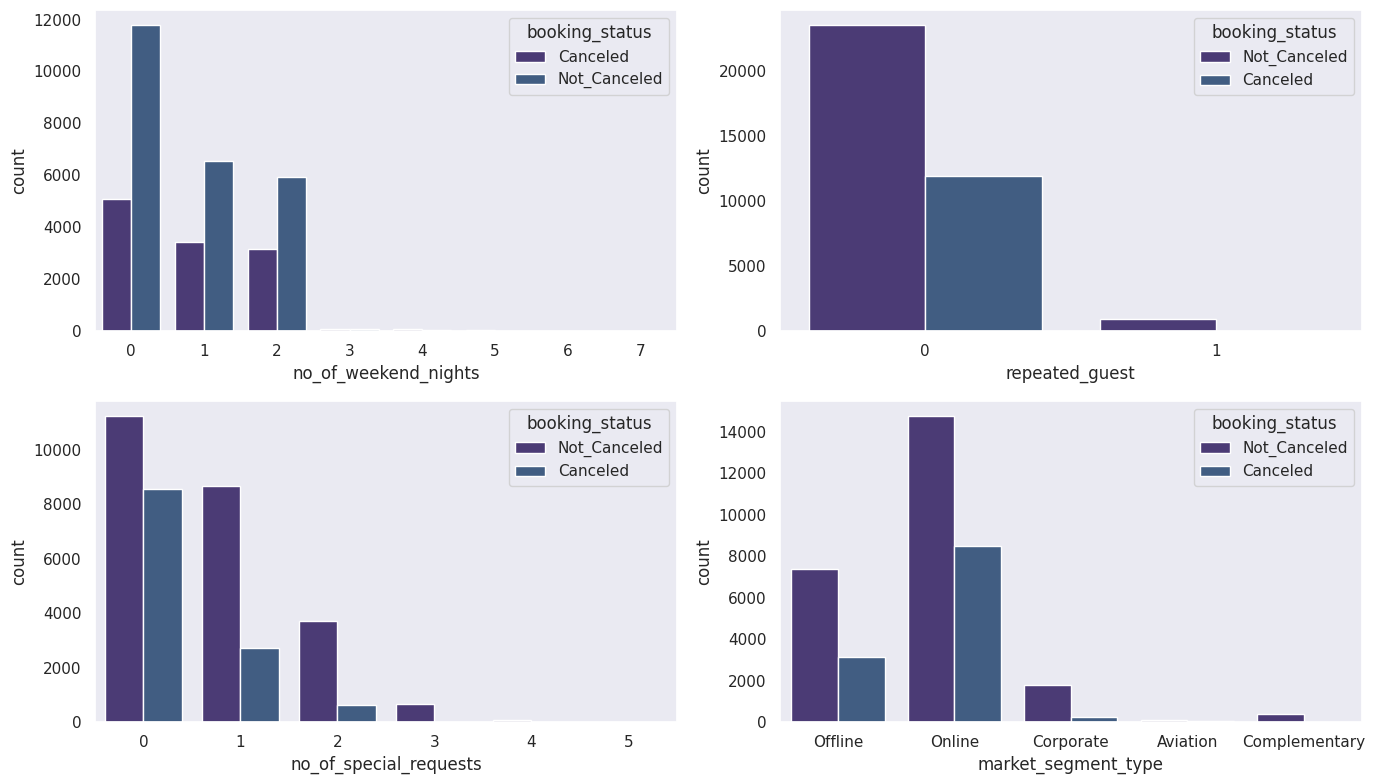

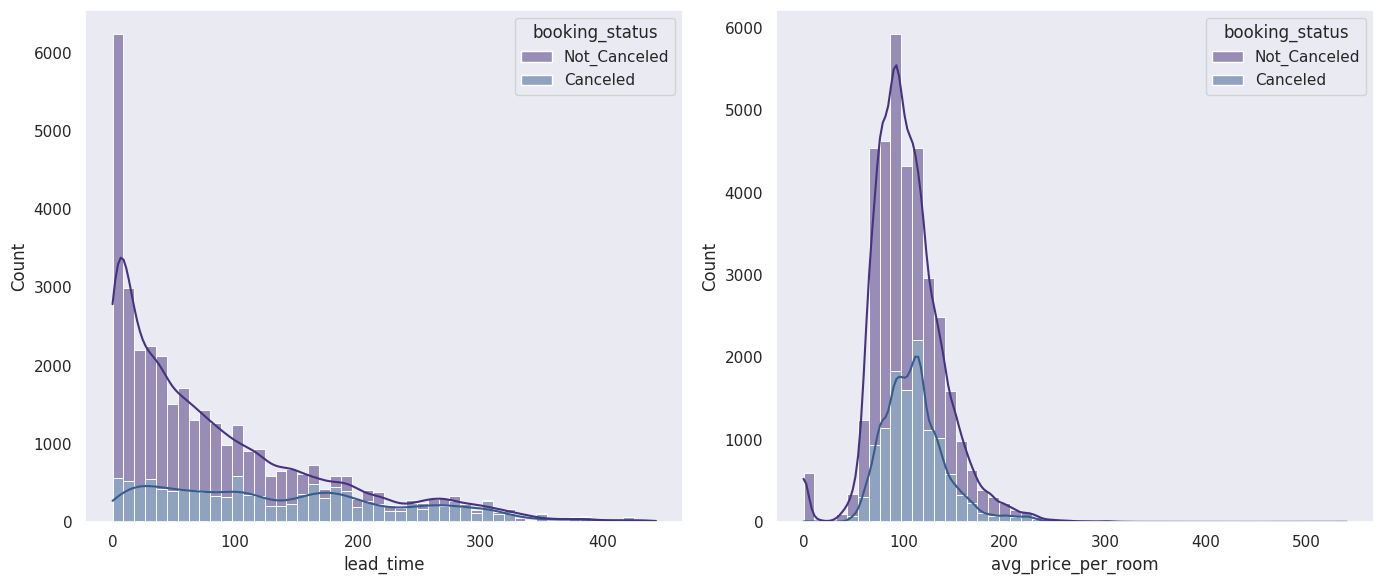

In [ ]:
plt.figure(figsize=(14, 8))
plot_count(data=df, column=["no_of_weekend_nights", "repeated_guest", "no_of_special_requests", "market_segment_type"], hue="booking_status", sub=[2, 2])
plt.figure(figsize=(14, 6))
plot_hist(data=df, column=["lead_time", "avg_price_per_room"], hue="booking_status", sub=[1, 2])

Alguns pontos interessantes:

1. A variável repeated_guest possui muita pouca variação. Clientes repetidos
não cancelaram nenhuma vez uma reserva.

2. Há um valor discrepante de hóspedes que cancelaram suas reservas que também não fizeram pedidos especiais nas suas compras.

3. Apesar dos valores de cancelamentos seguirem a distribuição de não cancelamentos, o número de hóspedes que cancelaram suas reservas e que compraram online é bem alto.

4. O preço médio do quarto não parece afetar muito se o cliente irá cancelar sua reserva.

5. Reservas canceladas predominam em tempos de espera de mais de 150 dias.

# Pré-processamento

Vamos criar um column transformer que irá:
1. Dropar a coluna de ano de chegada, pois se estamos criando um modelo para prever se um cliente irá cancelar a reserva, o ano em que o cliente está reservando não o influenciará. Apenas os meses e dias poderão ter alguma influência sobre a decisão de um cliente.
2. Codificar os atributos categóricos.
3. Padronizar os dados quando formos utilizar algoritmos baseados em distância.

In [ ]:
categorical_features = categorical_features.drop(columns=["booking_status"]).columns

In [ ]:
df = df.drop(columns=["arrival_year"])

In [ ]:
X, y = df.drop(columns=["booking_status"]), df["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_test = preprocessor(X_train, X_test, y_train=y_train, encoder=TargetEncoder(random_state=7, target_type="binary"))

# Modelagem

## Árvore de Decisão

Devido a interpretabilidade da Árvore de Decisão, iremos utilizá-la em primeiro momento para observar quais atributos são os mais importantes na hora do cancelamento de uma reserva.

In [94]:
tree = DecisionTreeClassifier(max_depth=3, random_state=7, class_weight={"Canceled": 2.05, "Not_Canceled": 1})
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={'Canceled': 2.05, 'Not_Canceled': 1},
                       max_depth=3, random_state=7)

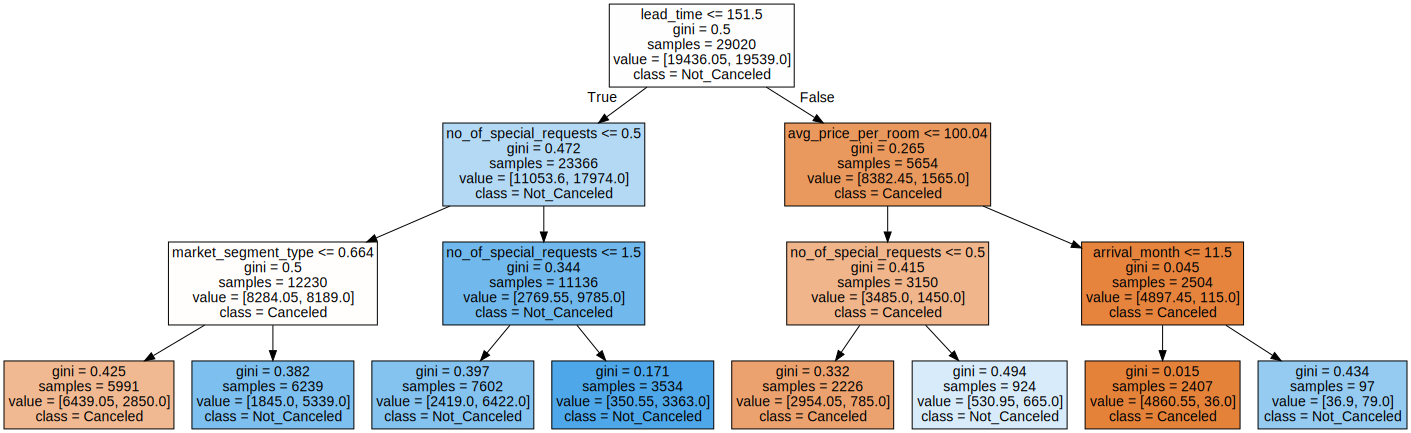

In [95]:
graphviz.Source(export_graphviz(tree, feature_names=X_train.columns, class_names=tree.classes_, filled=True))

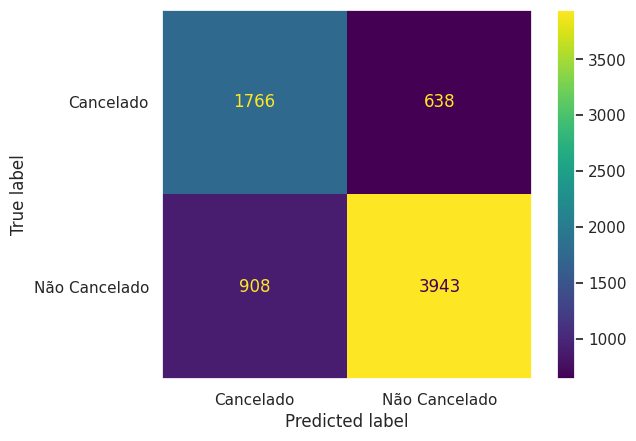

Cross Validation Score: 0.8215610880124536
              precision    recall  f1-score   support

    Canceled       0.66      0.73      0.70      2404
Not_Canceled       0.86      0.81      0.84      4851

    accuracy                           0.79      7255
   macro avg       0.76      0.77      0.77      7255
weighted avg       0.79      0.79      0.79      7255



In [96]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=["Cancelado", "Não Cancelado"])
plt.show()

cross_score = cross_val_score(tree, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(f"Cross Validation Score: {cross_score}")
print(classification_report(y_test, tree.predict(X_test)))

Note que possuímos um dataset desbalanceado, ou seja, se tivéssemos um modelo que nos retornasse que um cliente não irá cancelar o pedido sempre, **teríamos uma acurácia de 67%**.

Mesmo que uma Árvore de Decisão seja um algoritmo simples, **nosso modelo se ajustou bem aos dados com 79% de acurácia com apenas 3 níveis de profundidade. Se nós aumentarmos o nível de profundidade máximo para 5, teremos uma acurácia de 83%**. Visto que a classe que representa as reservas canceladas possui menores instâncias, ela teve as piores métricas.

Nosso atributo que mais nos dá informação na hora do split é o de tempo de espera entra a reserva e o check-in em dias. **Para nosso modelo, quanto mais tempo de espera entre a reserva e check-in, maior a probabilidade de nosso cliente fazer o cancelamento da reserva**.

Além disso, temos 2 folhas que possuem um coeficiente de impureza de gini muito baixo.

- Se nosso cliente fizer uma reserva com mais de 151 dias de espera, alugar um quarto de mais de 100 euros e o check-in for antes do meio de novembro, **há uma probabilidade de 98,5% dele cancelar a reserva!**

- Em contrapartida, um cliente que faz uma reserva com menos de 151 dias de espera e faz mais de 1 pedido especial, **possui uma probabilidade de 95% de não cancelar sua reserva!**

Identificar quais atributos influenciam o cliente a cancelar a reserva é muito importante para que o hotel possa se preparar, com campanhas de marketing ou ofertas, para eventuais cancelamentos caso o cliente caia nessas especificações.

## Random Forest

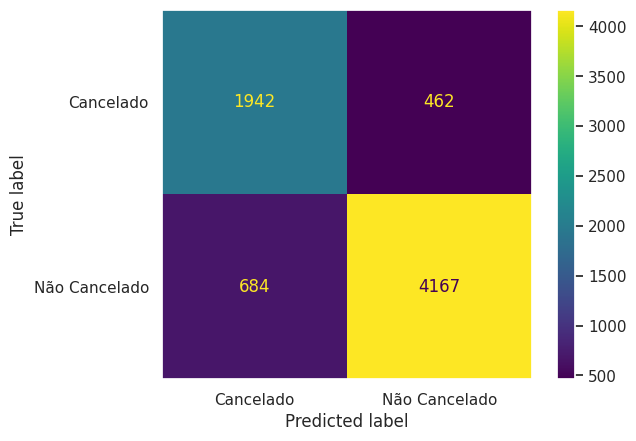

Cross Validation Score: 0.9116950808002962
              precision    recall  f1-score   support

    Canceled       0.74      0.81      0.77      2404
Not_Canceled       0.90      0.86      0.88      4851

    accuracy                           0.84      7255
   macro avg       0.82      0.83      0.83      7255
weighted avg       0.85      0.84      0.84      7255



In [90]:
random_tree = RandomForestClassifier(random_state=7, max_depth=7, n_jobs=-1, n_estimators=1000, class_weight={"Canceled": 2.05, "Not_Canceled": 1})
random_tree.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(random_tree, X_test, y_test, display_labels=["Cancelado", "Não Cancelado"])
plt.show()

cross_score = cross_val_score(random_tree, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(f"Cross Validation Score: {cross_score}")

print(classification_report(y_test, random_tree.predict(X_test)))

## XGBoost

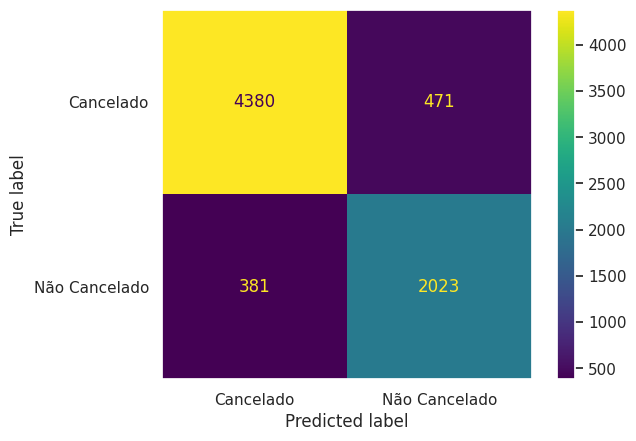

Cross Validation Score: 0.9472216324122904
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4851
           1       0.81      0.84      0.83      2404

    accuracy                           0.88      7255
   macro avg       0.87      0.87      0.87      7255
weighted avg       0.88      0.88      0.88      7255



In [92]:
y_train_copy = y_train.copy()
y_train_copy[y_train_copy == "Canceled"] = 1
y_train_copy[y_train_copy == "Not_Canceled"] = 0
y_train_copy = y_train_copy.astype(int)

y_test_copy = y_test.copy()
y_test_copy[y_test_copy == "Canceled"] = 1
y_test_copy[y_test_copy == "Not_Canceled"] = 0
y_test_copy = y_test_copy.astype(int)

xgb = XGBClassifier(random_state=7, max_depth=5, n_jobs=-1, n_estimators=1000, scale_pos_weight=2.05)
xgb.fit(X_train, y_train_copy)
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test_copy, display_labels=["Cancelado", "Não Cancelado"])
plt.show()

cross_score = cross_val_score(xgb, X_train, y_train_copy, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(f"Cross Validation Score: {cross_score}")
print(classification_report(y_test_copy, xgb.predict(X_test)))

## CatBoost

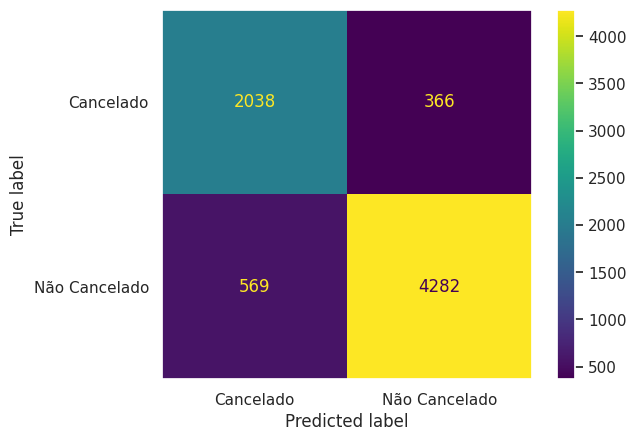

Cross Validation Score: 0.9439048253268199
              precision    recall  f1-score   support

    Canceled       0.78      0.85      0.81      2404
Not_Canceled       0.92      0.88      0.90      4851

    accuracy                           0.87      7255
   macro avg       0.85      0.87      0.86      7255
weighted avg       0.88      0.87      0.87      7255



In [93]:
cat = CatBoostClassifier(n_estimators=1000, max_depth=5, verbose=False, class_weights={"Canceled": 2.05, "Not_Canceled": 1}, random_state=7)
cat.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(cat, X_test, y_test, display_labels=["Cancelado", "Não Cancelado"])
plt.show()

cross_score = cross_val_score(cat, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1).mean()
print(f"Cross Validation Score: {cross_score}")
print(classification_report(y_test, cat.predict(X_test)))

Dois algoritmos se destacam: **XGBoost** e **CatBoost**

# Tunagem de hiperparâmetros - Randomized Search

## CatBoost

In [ ]:
cat_params = {
    "max_depth": range(3, 10),
    "learning_rate": np.linspace(0.01, 0.1, 10),
    "subsample": np.linspace(0.01, 1, 5),
    "colsample_bylevel": np.linspace(0.01, 1, 5),
    "min_child_samples": range(1, 100, 10),
}

cat_tuned = RandomizedSearchCV(cat, cat_params, n_jobs=-1, random_state=7)
cat_tuned.fit(X_train, y_train)

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x78851fd5fa00>,
                   n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': range(3, 10),
                                        'min_child_samples': range(1, 100, 10),
                                        'subsample': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ])},
                   random_state=7)

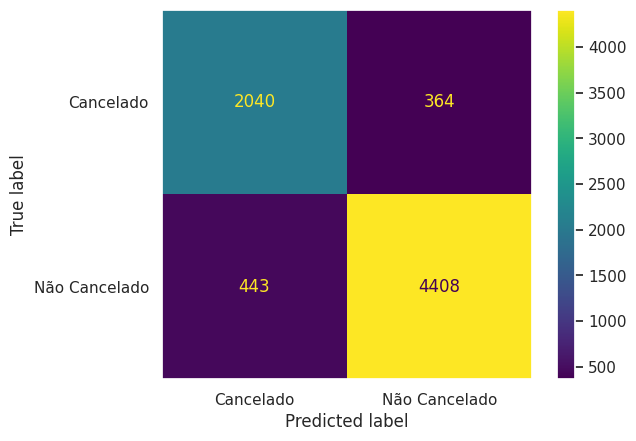

              precision    recall  f1-score   support

    Canceled       0.82      0.85      0.83      2404
Not_Canceled       0.92      0.91      0.92      4851

    accuracy                           0.89      7255
   macro avg       0.87      0.88      0.88      7255
weighted avg       0.89      0.89      0.89      7255



In [ ]:
ConfusionMatrixDisplay.from_estimator(cat_tuned, X_test, y_test, display_labels=["Cancelado", "Não Cancelado"])
plt.show()
print(classification_report(y_test, cat_tuned.predict(X_test)))

## XGBoost

In [ ]:
xg_params = {
    "max_depth": range(3, 10),
    "learning_rate": np.linspace(0.01, 0.1, 10),
    "subsample": np.linspace(0.01, 1, 5),
    "colsample_bylevel": np.linspace(0.01, 1, 5),
    "gamma": np.linspace(0.5, 5, 10)
}

xg_tuned = RandomizedSearchCV(xgb, xg_params, n_jobs=-1, random_state=7)
xg_tuned.fit(X_train, y_train_copy)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=1000, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=7, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'gamma': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'max_depth': range(3, 10),
                                        'subsample': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ])},
                   random_state=7)

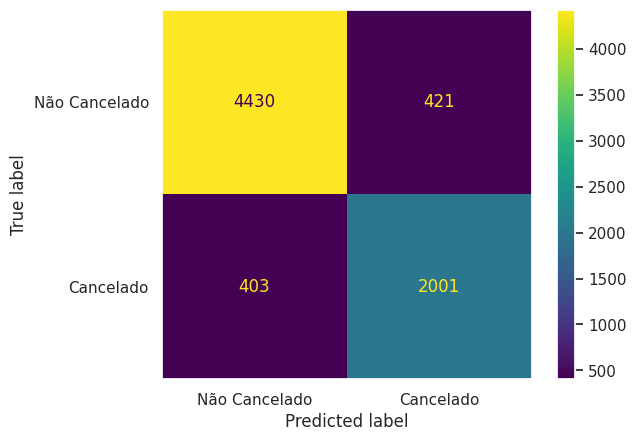

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4851
           1       0.83      0.83      0.83      2404

    accuracy                           0.89      7255
   macro avg       0.87      0.87      0.87      7255
weighted avg       0.89      0.89      0.89      7255



In [ ]:
ConfusionMatrixDisplay.from_estimator(xg_tuned, X_test, y_test_copy, display_labels=["Não Cancelado", "Cancelado"])
plt.show()

print(classification_report(y_test_copy, xg_tuned.predict(X_test)))

# Análise de negócio

Para decidir qual métrica usar vamos considerar alguns cenários:

1. Se o algoritmo classificar corretamente um cliente que não irá cancelar a reserva, o hotel não sofrerá prejuízo.
2. Se o algoritmo classificar corretamente um cliente que irá cancelar a reserva, o hotel poderá fazer alguma oferta, promoção ou solução de marketing para recuperar o cliente. Neste caso, o hotel irá gastar com a oferta, mas manterá a receita se o cliente for recuperado.
3. Se o algoritmo classificar incorretamente um cliente que não irá cancelar a reserva, o hotel gastará com promoção ou ofertas para um cliente que não iria cancelar a reserva em primeiro lugar.
4. Se o algoritmo classificar incorretamente um cliente que irá cancelar a reserva, o hotel perderá um cliente.

No (2) cenário, digamos que o hotel ofereça um desconto de 10% no preço do quarto e ofereça um pedido especial para o cliente, caso ele aceite, o hotel manterá uma receita menor, mas preferível do que perder um cliente.

No (3) cenário, o hotel terá uma receita menor do que potencialmente poderia ter, visto que o cliente não iria cancelar a reserva mesmo sem as ofertas.

No (4) cenário, o hotel perdeu totalmente a receita.

Como solução para um cliente que o modelo previu que iria cancelar sua reserva, vamos oferecer a seguinte oferta:

> Ganhe 15% de desconto e um pedido especial para o seu quarto.

**OBS.:** Os dados não oferecem o preço do quarto na hora da reserva, mas nos oferece a média dos preços no dia, visto que os preços mudam rapidamente. Aplicaremos esse desconto em cima dessa média.

Dessa forma, vamos selecionar os clientes que o nosso modelo previu que iriam cancelar a hospedagem:


In [ ]:
predictions = cat_tuned.predict(X_test)
predictions = pd.Series(predictions, index=y_test.index, name="booking_status")

In [ ]:
true_positive = predictions[y_test == predictions]
true_positive = true_positive[true_positive == "Canceled"]
true_positive = X_test[X_test.index.isin(true_positive.index)]
true_positive

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
17262,2,0,0,2,0.549487,0,0.677778,320,8,18,0.702635,0,0,0,115.00,1
31522,2,1,2,0,0.689258,0,0.677778,167,8,21,0.635160,0,0,0,119.70,1
10054,1,0,1,3,0.689258,0,0.677778,92,7,6,0.635160,0,0,0,68.00,2
5589,2,0,1,3,0.689258,0,0.677778,199,4,14,0.635160,0,0,0,106.20,1
8922,3,0,2,2,0.689258,0,0.665162,23,11,25,0.635160,0,0,0,154.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36142,3,0,0,4,0.689258,0,0.665162,37,4,27,0.635160,0,0,0,148.95,0
5771,3,0,1,3,0.689258,0,0.665162,175,8,15,0.635160,0,0,0,130.05,0
1019,1,2,2,3,0.689258,0,0.572124,10,5,13,0.635160,0,0,0,215.00,0
26572,2,0,2,5,0.689258,0,0.677778,167,9,3,0.635160,0,0,0,119.85,0


Vamos aplicar o desconto de 15% no preço dos quartos reservados e ver quanto o hotel ganhará caso o cliente não cancele.

In [ ]:
price = true_positive["avg_price_per_room"] * 0.85
print(f"O ganho de receita total com o não cancelamento dos clientes foi de {price.sum():.2f} euros.")

O ganho de receita total com o não cancelamento dos clientes foi de 192843.64 euros.




---

Agora, vamos calcular a perda de receita com os clientes que não iriam cancelar as reservas, mas que foram previstos pelo modelo que iriam.

In [ ]:
false_positive = predictions[y_test != predictions]
false_positive = false_positive[false_positive == "Canceled"]
false_positive = X_test[X_test.index.isin(false_positive.index)]
false_positive

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
32021,2,0,1,0,0.666424,0,0.677778,46,5,22,0.63516,0,0,0,116.10,0
5459,2,2,1,3,0.689258,0,0.572124,43,3,24,0.63516,0,0,0,186.40,1
28575,2,0,0,1,0.689258,0,0.677778,10,9,17,0.63516,0,0,0,152.00,1
33908,2,0,2,8,0.689258,0,0.665162,58,3,1,0.63516,0,0,0,85.30,1
17195,2,1,2,2,0.689258,0,0.665162,242,10,28,0.63516,0,0,0,95.13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10172,3,0,1,3,0.689258,0,0.665162,98,12,26,0.63516,0,0,0,111.69,0
34794,2,0,1,1,0.689258,0,0.677778,103,8,8,0.63516,0,0,0,76.50,1
32784,2,0,2,5,0.689258,0,0.677778,38,3,11,0.63516,0,0,0,81.90,1
16123,2,0,0,1,0.666424,0,0.677778,1,2,26,0.63516,0,0,0,79.00,0


Vamos aplicar novamente o desconto

In [ ]:
price = false_positive["avg_price_per_room"] * 0.15
print(f"A perda de receita com ofertas para clientes que não iriam cancelar foi de {price.sum():.2f} euros.")

A perda de receita com ofertas para clientes que não iriam cancelar foi de 7380.00 euros.




---
Por fim, vamos calcular a perda de receita dos clientes que canceleram a compra, mas não foram previstos pelo modelo.


In [ ]:
false_negative = predictions[y_test != predictions]
false_negative = false_negative[false_negative == "Not_Canceled"]
false_negative = X_test[X_test.index.isin(false_negative.index)]
false_negative

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
8721,1,0,0,2,0.689258,0,0.665162,8,5,10,0.63516,0,0,0,108.57,1
12714,2,1,2,5,0.689258,0,0.677778,132,7,2,0.63516,0,0,0,114.75,2
8841,3,0,1,1,0.549487,1,0.665162,100,5,14,0.63516,0,0,0,219.60,2
32119,2,2,2,4,0.689258,0,0.572124,63,4,10,0.63516,0,0,0,167.45,1
30793,2,0,1,4,0.689258,0,0.677778,143,9,21,0.63516,0,0,0,129.60,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17940,2,0,1,2,0.689258,0,0.677778,106,11,4,0.63516,0,0,0,90.00,2
22209,2,0,0,1,0.689258,0,0.665162,66,6,17,0.63516,0,0,0,108.11,0
28988,2,0,0,3,0.689258,0,0.677778,97,11,16,0.63516,0,0,0,90.00,1
32134,2,0,0,4,0.549487,0,0.665162,78,4,12,0.63516,0,0,0,136.00,1


In [ ]:
price = false_negative["avg_price_per_room"] * 0.85
print(f"A perda de receita com o cancelamento dos clientes que não foram previstos foi de {price.sum():.2f} euros.")

A perda de receita com o cancelamento dos clientes que não foram previstos foi de 32585.02 euros.


Portanto, a perda de receita total foi de: **32.582,02 + 7.380 = 39.962,02 euros**.

## Resultado

Como vimos, ganharíamos um valor de **€192843.64** com o não cancelamento das reservas caso o modelo previsse corretamente os clientes que iriam cancelar.

Entretanto, sofreríamos uma perda de receita de **€39.962,02**.

Com isso, teríamos um **EVITAÇÃO DE PERDA** de **€152.881,62!**

Note que nós sequer aplicamos uma tunagem de hiperparâmetros complicada e nem utilizamos todo nosso arsenal algorítmico!

Além disso, a economia de receita não é o único ponto em que o hotel pode se utilizar das previsões de nosso modelo. É possível utilizá-lo para:
- Otimizar os recursos com o pessoal e preparação de quartos que estariam reservados para clientes que não compareceriam.
- Reagir rapidamente a cancelamentos para relistar quartos e evitar perda de receita.
- Ajustar previsões de ocupação, ajudando a manter um equilíbrio adequado entre demanda e oferta de quartos.

## Alternativas

Se aumentarmos o desconto para 30%, teremos um lucro de **€117.217,70**.

Se utilizássemos o **XGBoost**, teríamos um lucro de **€146.680,33**.